<br>

<h1 style="text-align:center;"> Task 3: Plant Instance Segmentation</h1>

## Overview

---

Instance segmentation is the task of classifying and distinguishing each individual object (i.e. instance) in an image at the pixel level. Unlike semantic segmentation, which groups all objects of the same class together, instance segmentation differentiates each distinct object, even if they belong to the same class.

<div style="width: 300px;">

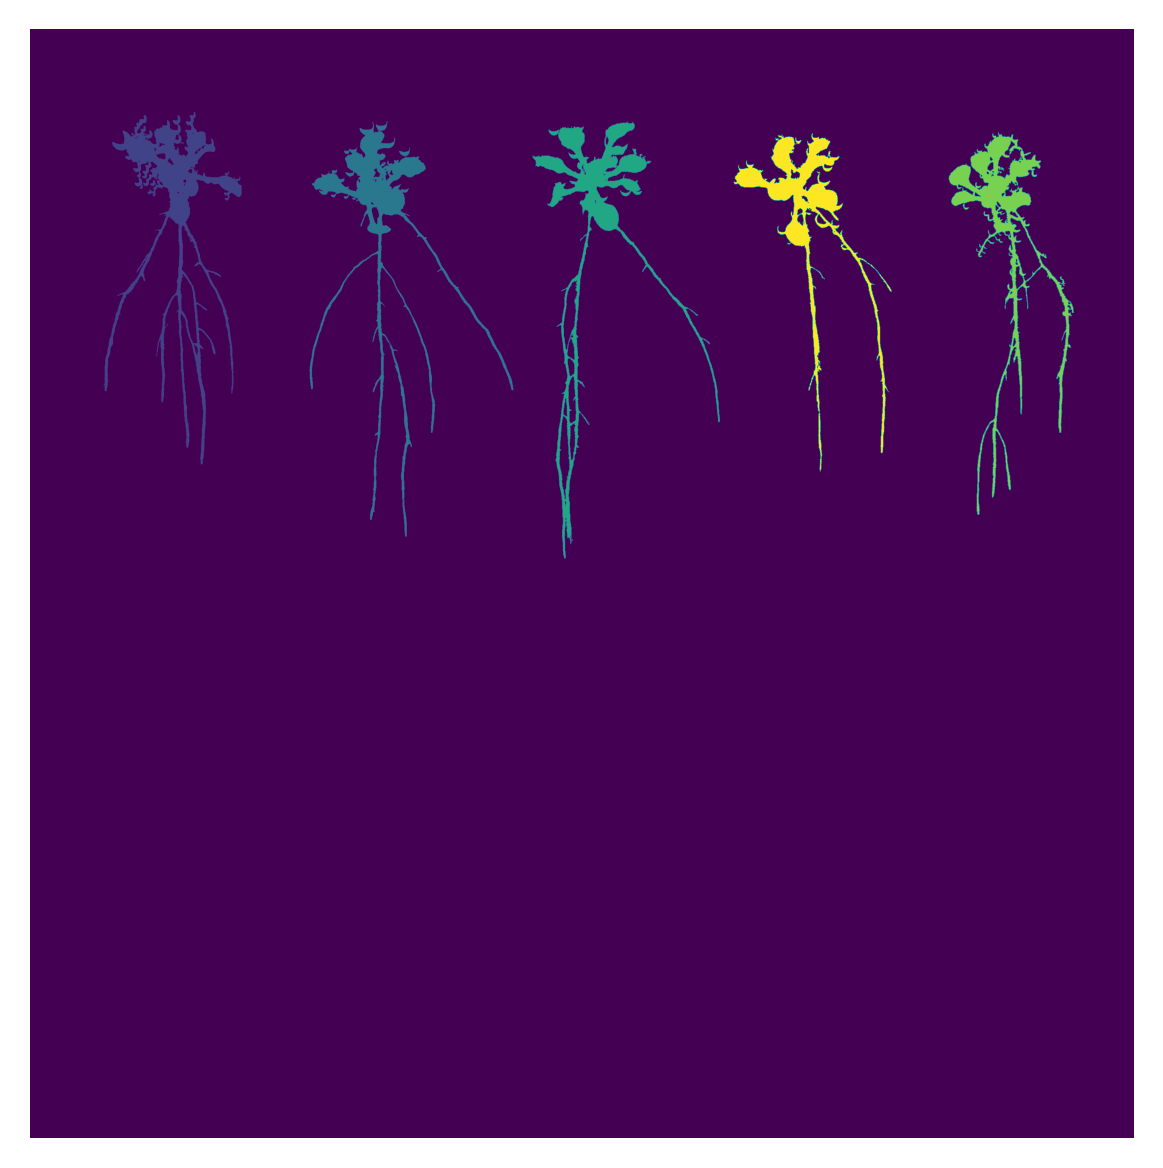

</div>
   
The objective is to perform instance segmentation for five plants using only traditional computer vision techniques. The segmentation should identify individual plants, not plant organs.

<br>

## Initial Setup

---

In [5]:
# Import the libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

<br>

## Extract Petri Dish

---

In this section, we processed an input image to extract a square region containing a Petri dish by converting the image to grayscale, applying Gaussian blur, using Otsu's thresholding, finding contours, and cropping the image based on the largest contour.

In [6]:
def extract_petri_dish(image):
    """
    Extracts a square region containing the Petri dish from the input image.
    
    Args:
        image: Input grayscale image
        
    Returns:
        Cropped square image containing the Petri dish
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu's thresholding to separate dish from background
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (should be the Petri dish)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Calculate the size of the square crop (use larger dimension)
    size = max(w, h)
    
    # Calculate new coordinates to center the dish
    center_x = x + w//2
    center_y = y + h//2
    
    # Calculate crop coordinates
    x1 = max(0, center_x - size//2)
    y1 = max(0, center_y - size//2)
    x2 = min(image.shape[1], x1 + size)
    y2 = min(image.shape[0], y1 + size)
    
    # Crop the image
    cropped = image[y1:y2, x1:x2]
    
    return cropped

<br>

## Segment Plants

---

In this section, we segmented individual plants in an input image by converting it to grayscale, normalizing and enhancing contrast, applying thresholding, finding connected components, and coloring each valid plant differently based on specific criteria.



In [7]:
def segment_plants(image):
    """
    Segments individual plants in the image using traditional CV methods.
    
    Args:
        image: Input BGR image
        
    Returns:
        colored_mask: Image with each plant colored differently
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Normalize image
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Enhance contrast before thresholding
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(blurred)

    # Apply thresholding
    _, binary = cv2.threshold(enhanced, 140, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((3, 1), np.uint8)
    # binary = cv2.erode(binary, kernel, iterations=1)
    binary = cv2.dilate(binary, kernel, iterations=1)
    
    # Find connected components
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    
    # Create edge mask
    edge_mask = np.zeros_like(labels, dtype=bool)
    edge_mask[0:260, :] = True      # Top edge
    edge_mask[-300:, :] = True      # Bottom edge
    edge_mask[:, 0:200] = True      # Left edge
    edge_mask[:, -140:] = True      # Right edge
    
    # Define colors for the plants (BGR format)
    plant_colors = [
        [180, 120, 240],  # Soft purple
        [240, 180, 120],  # Soft orange
        [120, 240, 180],  # Soft mint
        [180, 240, 120],  # Soft lime
        [240, 120, 180],  # Soft pink
    ]
    
    # Create output image with black background
    background_color = [20, 20, 30]  # BGR format
    colored_mask = np.ones((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    colored_mask[:] = background_color

    # Collect valid plants
    valid_plants = []
    for i in range(1, retval):
        x, y, w, h, area = stats[i]
        if (
            area > 1500 and              # Minimum area
            h > 200 and                  # Minimum height
            h/w > 0.4 and                # Height/width ratio
            y < image.shape[0]*0.95 and  # Not too close to bottom
            w < image.shape[1]*0.5       # Not too wide (to exclude background)
        ):
            valid_plants.append((i, h, x))
    
    # Sort plants by x-coordinate (left to right)
    valid_plants.sort(key=lambda x: x[2])
    
    # Color each plant
    for color_idx, (plant_label, height, x) in enumerate(valid_plants):
        if color_idx < len(plant_colors):
            mask = (labels == plant_label) & ~edge_mask
            colored_mask[mask] = plant_colors[color_idx]
    
    return colored_mask

<br>

## Display Results

---

In this section, we created a function to display the original and segmented images side by side using Matplotlib, allowing for visual comparison by setting up a figure with two subplots and displaying the images with appropriate titles.



In [9]:
def display_results(original, segmented, title):
    """
    Displays the original and segmented images side by side for comparison.

    Args:
        original (numpy.ndarray): The original BGR image
        segmented (numpy.ndarray): The segmented image with colored plant instances
        title (str): The title to display above the figure
        
    Returns:
        None: Displays the matplotlib figure directly
    """    

    # Figure size
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Segmented image
    plt.subplot(122)
    plt.imshow(segmented)
    plt.title('Segmented Plants')
    plt.axis('off')

    # Title
    plt.suptitle(title)

    # Display the figure
    plt.show()

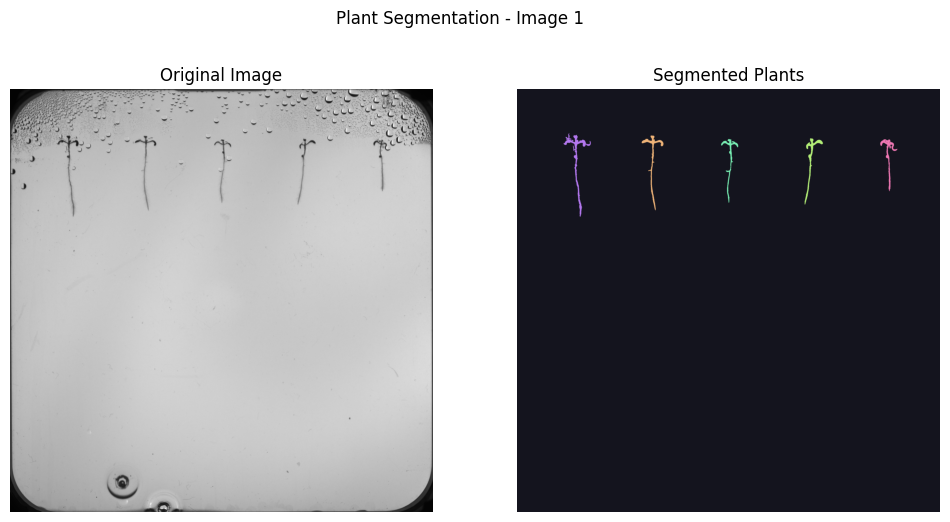

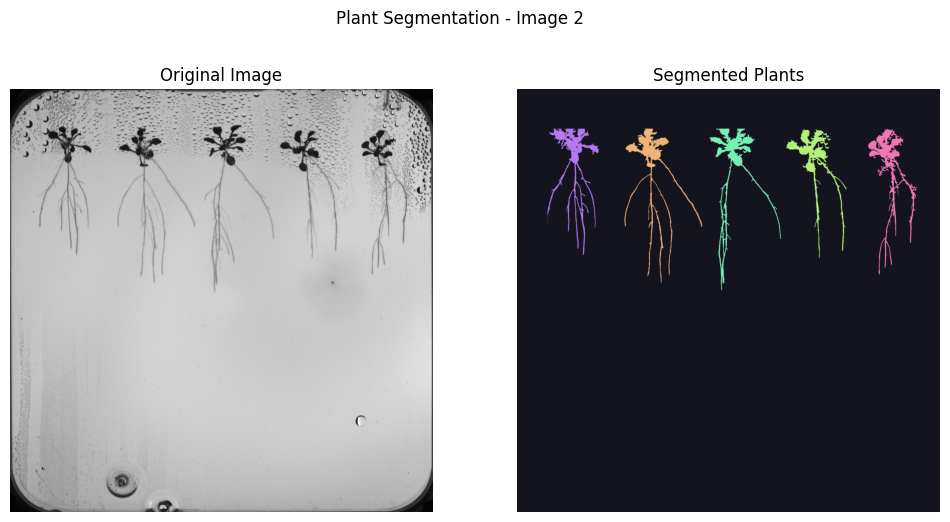

In [10]:
# Example usage:
# Load and process images
img1 = cv2.imread('task_3_image_1.png')
img1 = extract_petri_dish(img1)
segmented1 = segment_plants(img1)
display_results(img1, segmented1, 'Plant Segmentation - Image 1')

img2 = cv2.imread('task_3_image_2.png')
img2 = extract_petri_dish(img2)
segmented2 = segment_plants(img2)
display_results(img2, segmented2, 'Plant Segmentation - Image 2')